# **Download the files**

In [31]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [32]:
import requests
url = "https://drive.google.com/file/d/1kzwz_3ogZb67YbDMSQsslChxX-6xAUW2"
r = requests.get(url)
with open('models.zip', 'wb') as f:
    f.write(r.content) 

In [33]:
!unzip /content/gdrive/MyDrive/models.zip

Archive:  /content/gdrive/MyDrive/models.zip
replace images/day.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# **Setup**

In [34]:
!mkdir outputs

mkdir: cannot create directory ‘outputs’: File exists


In [35]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = 21, 18

# **COCO Names Python File**

In [36]:
%%writefile coco_names.py
COCO_INSTANCE_CATEGORY_NAMES = ['obj','bike','bus','car','motor','person','rider','traffic light','traffic sign','train','truck']

Overwriting coco_names.py


# **Detection Utility Script**

In [37]:
%%writefile detect_utils.py
import torchvision.transforms as transforms
import cv2
import numpy as np

from coco_names import COCO_INSTANCE_CATEGORY_NAMES as coco_names

# this will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

# define the torchvision image transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

def predict(image, model, device, detection_threshold):
    # transform the image to tensor
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    outputs = model(image) # get the predictions on the image

    # get all the predicited class names
    pred_classes = [coco_names[i] for i in outputs[0]['labels'].cpu().numpy()]

    # get score for all the predicted objects
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()

    # get all the predicted bounding boxes
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get boxes above the threshold score
    boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)

    return boxes, pred_classes, outputs[0]['labels']

def draw_boxes(boxes, classes, labels, image):
    image = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image

Overwriting detect_utils.py


In [38]:
!pip install intel_extension_for_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Object Detection in Images**

In [39]:
%%writefile detect_img.py
import torchvision
import torch
import argparse
import cv2
import detect_utils
import time
import intel_extension_for_pytorch as ipex

start = time.time()

from PIL import Image

# construct the argument parser
parser = argparse.ArgumentParser()
parser.add_argument('-i', '--input', help='path to input image/video')
args = vars(parser.parse_args())

# define the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load the model
model = torch.load('/content/models/model.pt', map_location=torch.device('cpu'))
# load the model on to the computation device
model.eval().to(device)
model = ipex.optimize(model)
# read the image and run the inference for detections
image = Image.open(args['input'])
boxes, classes, labels = detect_utils.predict(image, model, device, 0.7)
image = detect_utils.draw_boxes(boxes, classes, labels, image)
# cv2.imshow('Image', image)
save_name = f"{args['input'].split('/')[-1].split('.')[0]}"
cv2.imwrite(f"outputs/{save_name}.jpg", image)
# cv2.waitKey(0)

end = time.time()

print(f"Execution time: {end - start} seconds")

Overwriting detect_img.py


In [40]:
!python detect_img.py --input /content/images/day.jpg

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/usr/local/lib/python3.10/dist-packages/intel_extension_for_pytorch/frontend.py:474: UserWarning: Conv BatchNorm folding failed during the optimize process.
  warnings.warn("Conv BatchNorm folding failed during the optimize process.")
/usr/local/lib/python3.10/dist-packages/intel_extension_for_pytorch/frontend.py:479: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn("Linear BatchNorm folding failed during the optimize process.")
Execution time: 1.9899437427520752 seconds


In [41]:
!python detect_img.py --input /content/images/night.jpg

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/usr/local/lib/python3.10/dist-packages/intel_extension_for_pytorch/frontend.py:474: UserWarning: Conv BatchNorm folding failed during the optimize process.
  warnings.warn("Conv BatchNorm folding failed during the optimize process.")
/usr/local/lib/python3.10/dist-packages/intel_extension_for_pytorch/frontend.py:479: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn("Linear BatchNorm folding failed during the optimize process.")
Execution time: 1.433464765548706 seconds


# **Output**

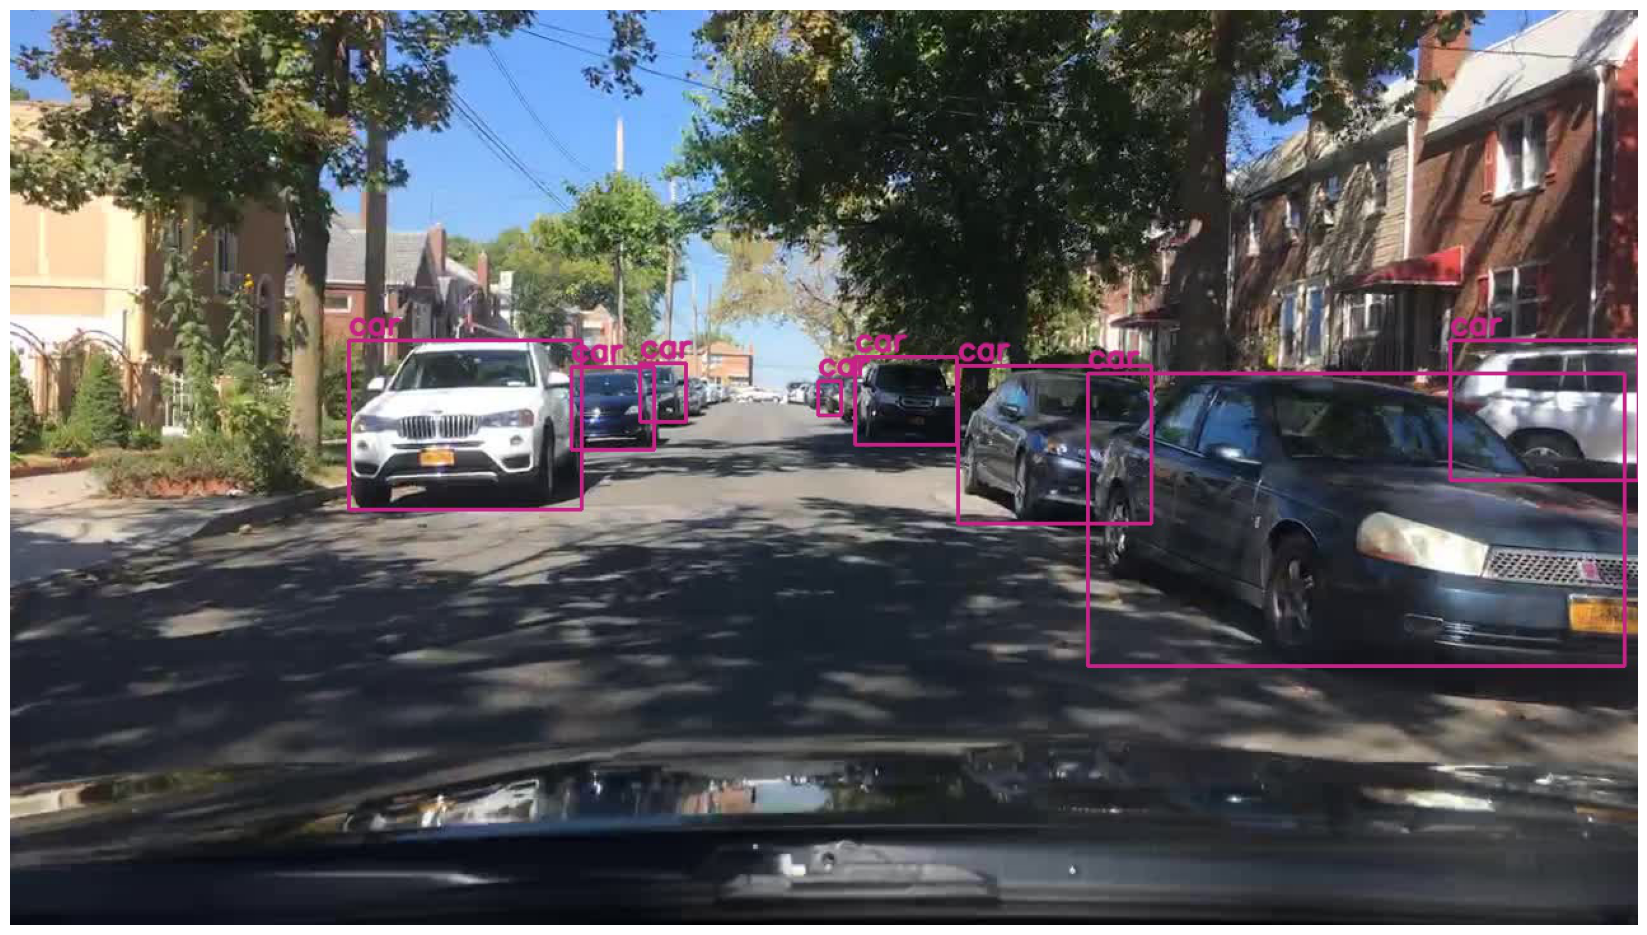

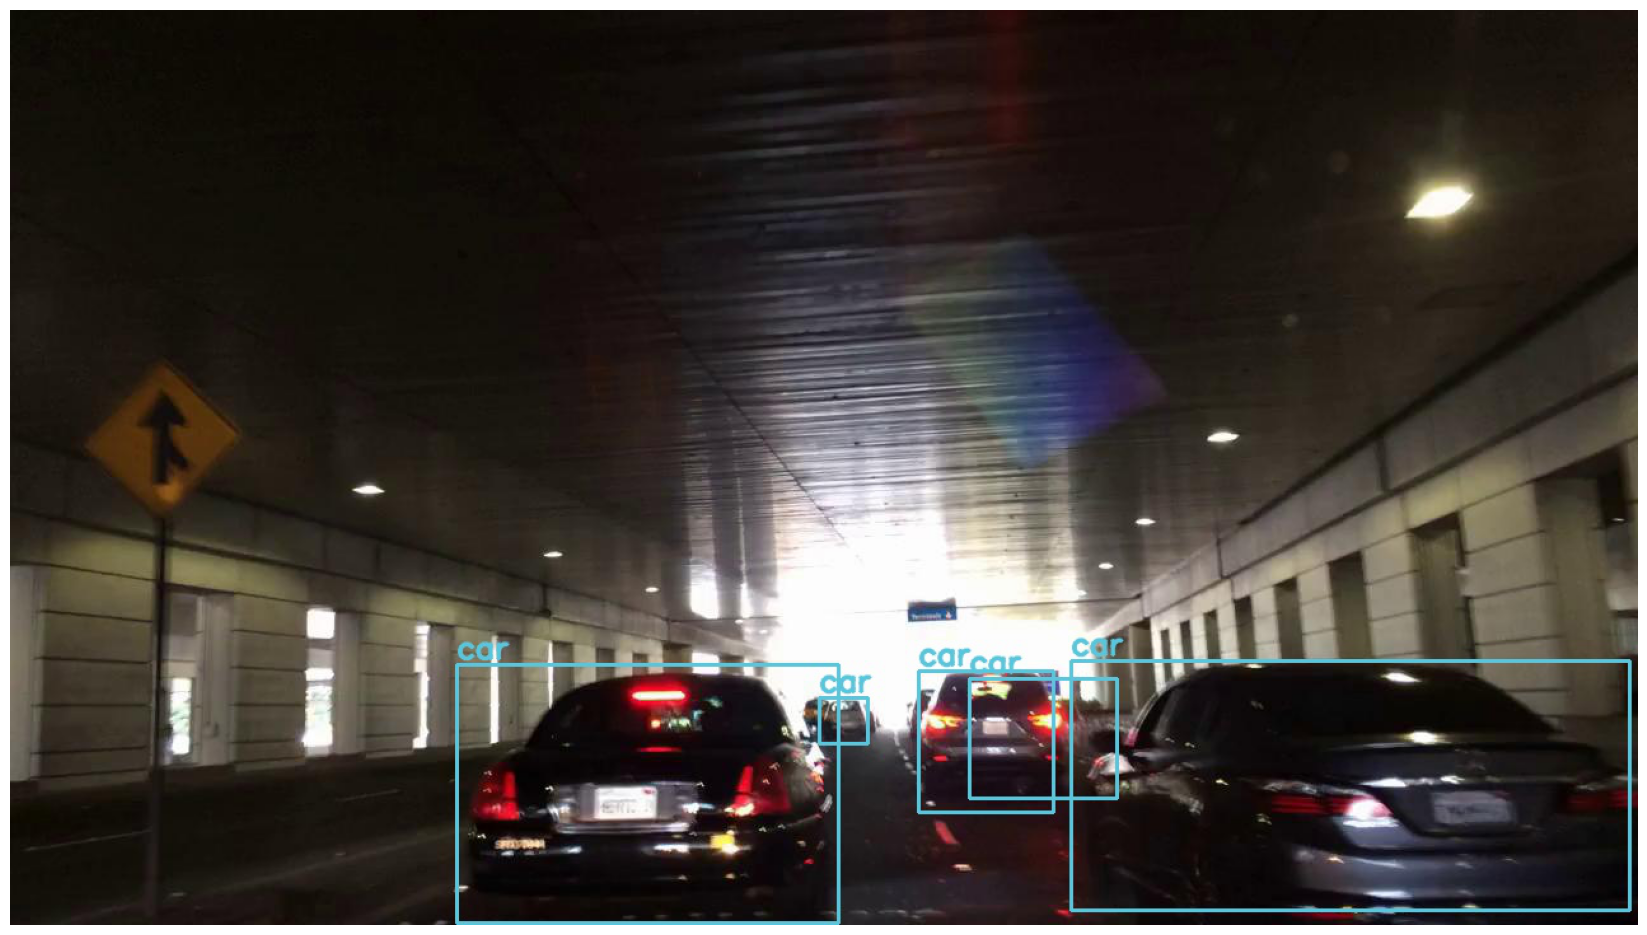

In [42]:
import matplotlib.pyplot as plt
import matplotlib


image_1 = plt.imread('/content/outputs/day.jpg')
image_2 = plt.imread('/content/outputs/night.jpg')

plt.imshow(image_1)
plt.axis('off')
plt.show()

plt.imshow(image_2)
plt.axis('off')
plt.show()

# **Analysis - Day Time Captured**

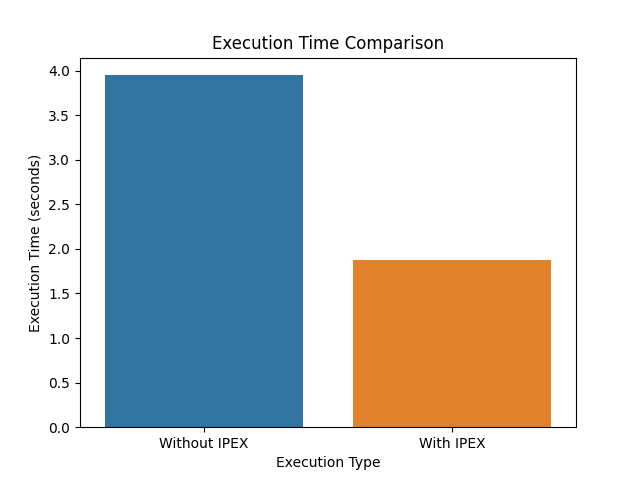

# **Analysis - Night Time Captured**

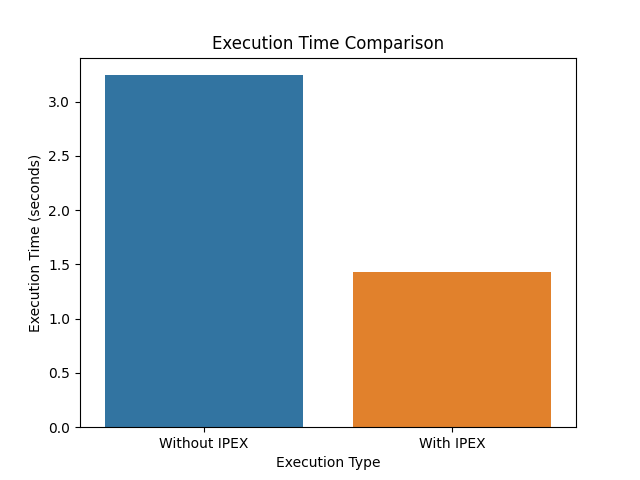